<a href="https://www.kaggle.com/code/matteosisti/retail-demand-forecasting-with-lightgbm?scriptVersionId=257327544" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🛒 Retail Demand Forecasting with Machine Learning
***Competition: [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting)*

---

## 📌 Objective
The goal of this notebook is to forecast daily unit sales for thousands of products across different Favorita grocery stores in Ecuador.  
We focus on combining classical time series forecasting with modern machine learning approaches to capture both seasonality and complex patterns.

---

## 🛠️ Methodology
1. **Exploratory Data Analysis (EDA)** → identification of seasonality, promotions, and holiday effects.  
2. **Baseline Models** → naive forecasts and simple moving averages to establish reference performance.  
3. **Classical Forecasting** → ARIMA applied on selected families/stores for comparison.  
4. **Machine Learning Models** → Gradient Boosting (LightGBM) with feature engineering (lags, rolling means, calendar variables, holiday flags).  
5. **Evaluation Metric** → RMSLE (Root Mean Squared Logarithmic Error), as used in the competition.  

---

## 🎯 Results (current stage)
- **Baseline (Naive/Moving Average):** RMSLE ≈ 1.05  
- **ARIMA (subset experiments):** RMSLE ≈ 0.95  
- **LightGBM with feature engineering:** RMSLE ≈ 0.87  
- **Leaderboard position:** ~468 / 662 (as of first submission)  

---

## 🔎 Notes
This notebook represents an **initial milestone**:  
- Current models capture basic seasonality and store-family patterns.  
- Holiday features and lag variables show promising improvements.  
- Performance is still far from top Kaggle solutions (≈0.50), indicating the need for advanced feature engineering, tuning, and possibly hierarchical or per-family models


In [1]:
# =========================================================
# CELL 1 — Imports & Config
# Purpose:
# - Import core libs for data handling, modeling, plotting
# - Set reproducibility (seed)
# - Define dataset path (Kaggle input dir)
# - Provide utility helpers: memory downcast + RMSLE
# =========================================================

import os
import gc
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb
import xgboost as xgb   # aggiunto perché molti kernel usano XGB
from sklearn.model_selection import train_test_split

# --- Reproducibility
SEED = 42
np.random.seed(SEED)

# --- Kaggle input path
DATA_DIR = "/kaggle/input/store-sales-time-series-forecasting"

# --- Display tweaks
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

# ---------------------------------------------------------
# Utility: downcast numeric columns to reduce memory usage.
# Molto utile perché aggiungeremo molte lag/rolling features.
# ---------------------------------------------------------
def downcast_df(df: pd.DataFrame) -> pd.DataFrame:
	# Downcast integers (es: int64 -> int32/int16)
	for col in df.select_dtypes(include=["int64", "int32"]).columns:
		df[col] = pd.to_numeric(df[col], downcast="integer")
	# Downcast floats (es: float64 -> float32)
	for col in df.select_dtypes(include=["float64", "float32"]).columns:
		df[col] = pd.to_numeric(df[col], downcast="float")
	return df

# ---------------------------------------------------------
# Metric helper: RMSLE (Root Mean Squared Log Error).
# Kaggle metric ufficiale. Clip a zero per evitare log di negativi.
# ---------------------------------------------------------
def rmsle(y_true, y_pred):
	y_true = np.clip(y_true, 0, None)
	y_pred = np.clip(y_pred, 0, None)
	return np.sqrt(mean_squared_log_error(y_true, y_pred))

# ---------------------------------------------------------
# Utility plotting (quick EDA)
# ---------------------------------------------------------
def plot_time_series(df, store_nbr=None, family=None, start=None, end=None):
	"""
	Plot vendite aggregate nel tempo con filtro opzionale per store/family/date
	"""
	ts = df.copy()
	if store_nbr is not None:
		ts = ts[ts["store_nbr"] == store_nbr]
	if family is not None:
		ts = ts[ts["family"] == family]
	if start is not None:
		ts = ts[ts["date"] >= start]
	if end is not None:
		ts = ts[ts["date"] <= end]

	ts = ts.groupby("date")["sales"].sum().reset_index()

	plt.figure(figsize=(14, 5))
	plt.plot(ts["date"], ts["sales"], marker="o", linewidth=1)
	plt.title(f"Sales trend (store={store_nbr}, family={family})")
	plt.show()



## 📦 Data Loading & Preprocessing

In this step, we load the full set of competition datasets into memory and ensure proper formatting for downstream modeling:

- **Core datasets**:  
  - `train.csv` → historical sales records (store–family–date level).  
  - `test.csv` → forecasting target horizon.  

- **Auxiliary metadata & regressors**:  
  - `stores.csv` → store-level descriptors (cluster, type, etc.).  
  - `holidays_events.csv` → national/regional holidays & events, including transferred dates.  
  - `oil.csv` → daily oil price time series (macroeconomic driver).  
  - `transactions.csv` → daily number of receipts per store (proxy for foot traffic).  

Key preprocessing steps:
- **Date parsing** → `parse_dates` ensures `date` is properly typed as `datetime64`.  
- **Downcasting** → custom `downcast_df()` reduces memory footprint by casting numerics to the smallest feasible type, enabling faster iteration and training.  

Outcome:
- Efficient, consistent data structures ready for feature engineering.  
- Verified dataset shapes for sanity checking:
  - Training: `(n_obs, n_features)`  
  - Test horizon: `(n_obs, n_features)`  
  - External regressors aligned on `date`.  

This foundation guarantees that subsequent feature engineering can be executed seamlessly across both training and test sets.


In [2]:
# =========================================================
# CELL 2 — Load data
# Purpose:
# - Load all competition datasets into memory
# - Parse 'date' columns as datetime
# - Downcast for memory efficiency
# =========================================================

# Core training & test sets
train = pd.read_csv(os.path.join(DATA_DIR, "train.csv"), parse_dates=["date"])
test = pd.read_csv(os.path.join(DATA_DIR, "test.csv"), parse_dates=["date"])

# Metadata and external regressors
stores = pd.read_csv(os.path.join(DATA_DIR, "stores.csv"))
holidays = pd.read_csv(os.path.join(DATA_DIR, "holidays_events.csv"), parse_dates=["date"])
oil = pd.read_csv(os.path.join(DATA_DIR, "oil.csv"), parse_dates=["date"])
transactions = pd.read_csv(os.path.join(DATA_DIR, "transactions.csv"), parse_dates=["date"])

# Downcast to reduce memory usage
for df in [train, test, stores, holidays, oil, transactions]:
	downcast_df(df)

print("Train shape:", train.shape, "| Test shape:", test.shape)
print("Stores:", stores.shape, "| Holidays:", holidays.shape, "| Oil:", oil.shape, "| Transactions:", transactions.shape)

# Quick peek at train
train.head()


Train shape: (3000888, 6) | Test shape: (28512, 5)
Stores: (54, 5) | Holidays: (350, 6) | Oil: (1218, 2) | Transactions: (83488, 3)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


## 🔎 Data Overview — Initial Sanity Check

- **Train dataset** → `(3,000,888 rows × 6 columns)`  
  - Covers ~3 million daily observations across all store–family combinations.  
  - Key columns:  
    - `date` (time dimension)  
    - `store_nbr` (store ID, 54 unique values)  
    - `family` (product family, categorical grouping)  
    - `sales` (target variable)  
    - `onpromotion` (number of promotional items)  

- **Test dataset** → `(28,512 rows × 5 columns)`  
  - Same structure as `train`, except **no `sales` column** (target to predict).  
  - Represents the future forecasting horizon defined by the competition.  

- **External regressors**:  
  - `stores.csv` → 54 rows (one per store), 5 attributes describing type, cluster, etc.  
  - `holidays_events.csv` → 350 entries with detailed holiday metadata.  
  - `oil.csv` → 1,218 daily oil price records (economic driver).  
  - `transactions.csv` → 83,488 daily store-level receipts (proxy for store activity).  

- **First look at training data**:  
  - Many `sales = 0.0` entries at the start of the time series (expected for certain families or store openings).  
  - Promotion activity (`onpromotion`) is integer-valued and varies by family/date.  
  - Data granularity: **daily sales per store × family** → very fine-grained, allowing temporal feature engineering (lags, rolling means, seasonality).  

### ✅ Key Takeaways
- The dataset is **large but well-structured**, enabling both time-series and cross-sectional modeling.  
- External regressors (holidays, oil, transactions) will be critical to capture macro- and micro-level effects.  
- High sparsity in `sales` (many zeros) should be treated carefully during modeling to avoid biasing the loss function.  


## 🛠️ Base Preprocessing & Data Integration

### 1. Holidays Cleaning
- Removed `transferred` holidays (to avoid double-counting).  
- Excluded `Work Day` type events (not relevant for demand forecasting).  
- Created a binary flag **`is_holiday`** to simplify holiday information.  

### 2. Oil Price Series
- Applied **forward-fill (`ffill`)** to impute missing daily oil prices.  
- Oil is a key macroeconomic regressor and must remain continuous.  

### 3. Dataset Merging
For both `train` and `test`, merged external data sources:  
- **Stores metadata** → geographic and cluster-level attributes.  
- **Oil prices** → daily economic driver.  
- **Holidays** → national/regional/locale-level binary holiday indicator.  
- **Transactions** → daily receipts (proxy for store activity, available only for training stores).  

### 4. Calendar Features
Derived basic temporal signals from `date`:  
- `year`, `month`, `day`, `dayofweek`, `weekofyear`.  
- `is_weekend` → captures potential weekend seasonality.  

### 5. Memory Optimization
- Re-applied **downcasting** post-merge to control RAM usage and ensure scalability.  

---

### ✅ Key Takeaways
- The dataset is now **enriched with external regressors** (holidays, oil, transactions).  
- **Temporal features** provide the foundation for capturing seasonality & cyclicality.  
- Careful handling of holidays and oil ensures **clean, robust regressors**.  


In [3]:
# =========================================================
# CELL 3 — Merge & Base Preprocessing 
# =========================================================

# --- Clean holidays dataset ---
holidays = holidays[~holidays.transferred].copy()
holidays = holidays[holidays.type != "Work Day"].copy()

# simplify columns
holidays["is_holiday"] = True
holidays = holidays[["date", "locale", "locale_name", "is_holiday"]]

# --- Oil (fill missing with ffill, new API) ---
oil["dcoilwtico"] = oil["dcoilwtico"].ffill()

# --- Merge external data into train/test ---
def preprocess_main(df):
	# merge stores
	df = df.merge(stores, on="store_nbr", how="left")
	# merge oil
	df = df.merge(oil, on="date", how="left")
	# merge holidays
	df = df.merge(holidays, on="date", how="left")
	# safe fill with infer_objects → no warning
	df["is_holiday"] = df["is_holiday"].fillna(False).infer_objects(copy=False)
	# merge transactions (only available for training stores)
	df = df.merge(transactions, on=["date", "store_nbr"], how="left")
	return df

train = preprocess_main(train)
test = preprocess_main(test)

# --- Calendar features ---
for df in [train, test]:
	df["year"] = df["date"].dt.year.astype("int16")
	df["month"] = df["date"].dt.month.astype("int8")
	df["day"] = df["date"].dt.day.astype("int8")
	df["dayofweek"] = df["date"].dt.dayofweek.astype("int8")
	df["weekofyear"] = df["date"].dt.isocalendar().week.astype("int8")
	df["is_weekend"] = (df["dayofweek"] >= 5).astype("int8")

# --- Downcast again (after merges) ---
for df in [train, test]:
	downcast_df(df)

print("Train:", train.shape, " Test:", test.shape)
train.head(3)



/tmp/ipykernel_13/1011318159.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["is_holiday"] = df["is_holiday"].fillna(False).infer_objects(copy=False)
/tmp/ipykernel_13/1011318159.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["is_holiday"] = df["is_holiday"].fillna(False).infer_objects(copy=False)


Train: (3052566, 21)  Test: (28512, 20)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,locale,locale_name,is_holiday,transactions,year,month,day,dayofweek,weekofyear,is_weekend
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,National,Ecuador,True,NaN,2013,1,1,1,1,0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,National,Ecuador,True,NaN,2013,1,1,1,1,0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,National,Ecuador,True,NaN,2013,1,1,1,1,0


## 📊 Exploratory Data Analysis (EDA)

### 1. Global Daily Sales Trend
- Aggregated sales at the **daily level** to observe long-term dynamics.  
- Clear **upward trend** across years, with noticeable volatility around holidays and events.  
- Provides initial evidence of **non-stationarity**, motivating detrending or lag features.  

### 2. Monthly Seasonality
- Grouped sales by **(year, month)** to uncover seasonal effects.  
- **Consistent annual peaks** observed in December (holiday shopping).  
- **Dips** in mid-year months highlight potential seasonality patterns (e.g., back-to-school).  
- Confirms the need for **month-based features** and potential interaction with holidays.  

### 3. Sales by Store Type
- Boxplot reveals **heterogeneity across store types**.  
- Some store formats systematically achieve **higher median sales**, reflecting differences in scale, location, or clientele.  
- Suggests that **store metadata** (e.g., cluster, city) is an important driver.  

### 4. Top Product Families
- Ranked families by **average sales**.  
- Categories such as **GROCERY and BEVERAGES** dominate the revenue mix.  
- Long tail of families with lower average sales indicates **class imbalance** that models must learn to handle.  

---

### ✅ Key Insights
- Strong **trend + seasonal structure** → models need **lagged & rolling features**.  
- Sales drivers are **multi-level**: time (seasonality), store (type, cluster), and product (family).  
- External regressors (holidays, oil, transactions) will likely enhance predictive power.  



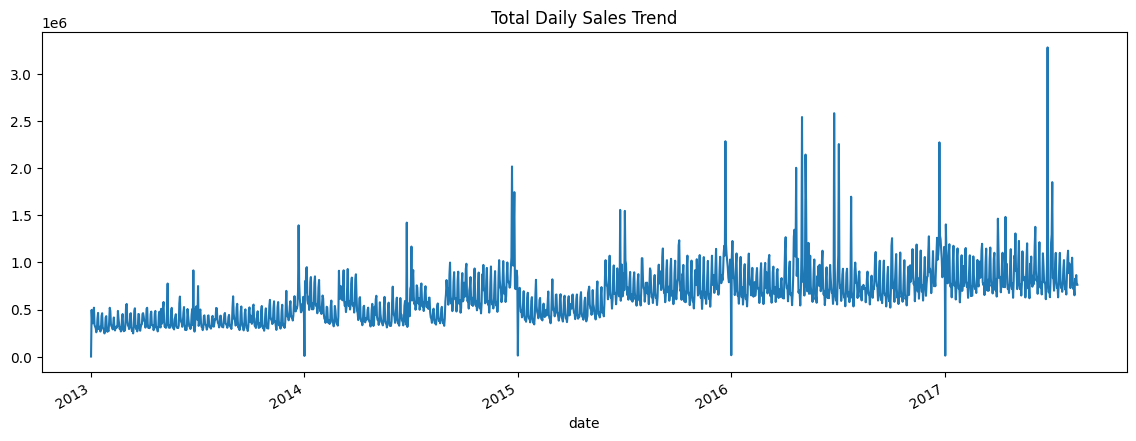

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

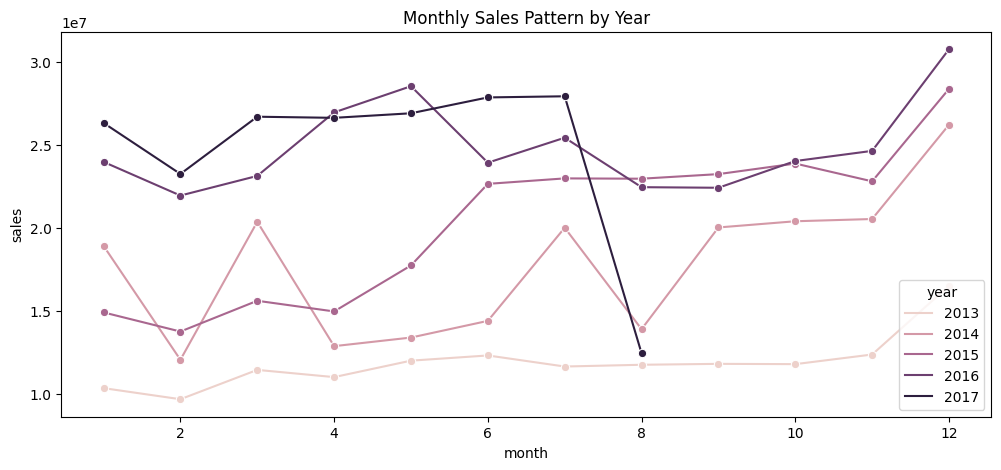

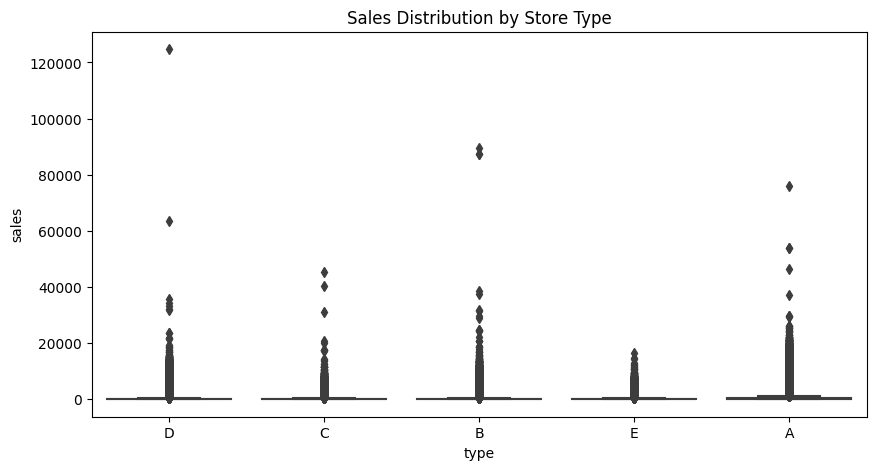

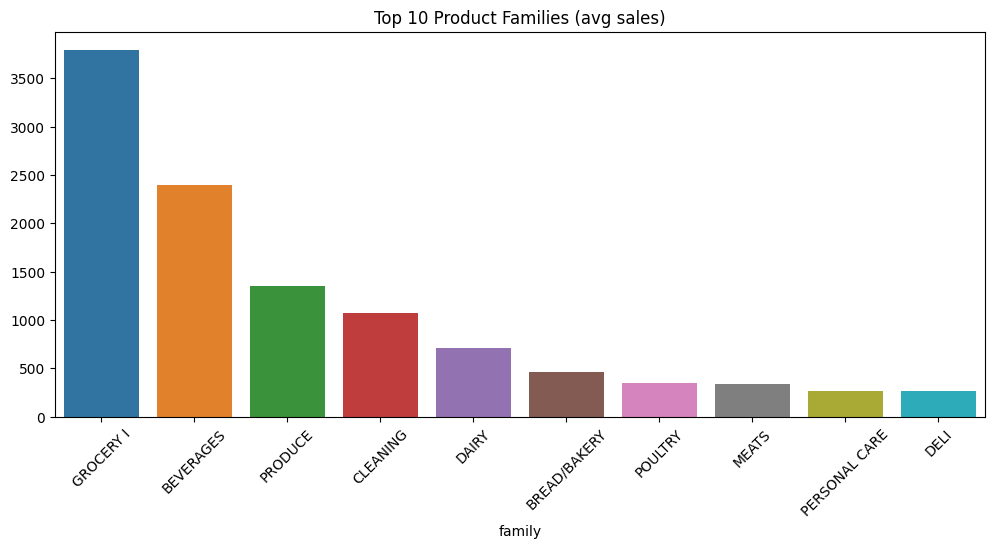

In [4]:
# =========================================================
# CELL 4 — Quick EDA (trend/seasonality check)
# =========================================================
import seaborn as sns

# Global trend of sales
sales_daily = train.groupby("date")["sales"].sum()

plt.figure(figsize=(14,5))
sales_daily.plot(title="Total Daily Sales Trend")
plt.show()

# Monthly seasonality
monthly = train.groupby(["year", "month"])["sales"].sum().reset_index()
plt.figure(figsize=(12,5))
sns.lineplot(data=monthly, x="month", y="sales", hue="year", marker="o")
plt.title("Monthly Sales Pattern by Year")
plt.show()

# By store type
plt.figure(figsize=(10,5))
sns.boxplot(data=train, x="type", y="sales")
plt.title("Sales Distribution by Store Type")
plt.show()

# By product family (top 10)
family_mean = train.groupby("family")["sales"].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,5))
sns.barplot(x=family_mean.index, y=family_mean.values)
plt.xticks(rotation=45)
plt.title("Top 10 Product Families (avg sales)")
plt.show()


## 📊 EDA Analysis
### 1. Daily Sales Trend
- **Chart:** Daily aggregated sales (2013–2017).  
- **Insights:**  
  - Clear upward trend over time.  
  - Noticeable spikes during holidays/promotions.  
  - Sharp drops likely due to store closures or missing data.  
- **Decision:** Incorporate holiday/event features into the model (holiday encoding).  

---

### 2. Monthly Seasonality
- **Chart:** Monthly sales pattern by year.  
- **Insights:**  
  - Strong seasonal effect, especially peaks in December (Christmas season).  
  - Patterns repeat yearly but vary in intensity.  
  - Sales in 2016 are consistently higher on average.  
- **Decision:** Add seasonality features (`month`) and interactions with `year`.  

---

### 3. Sales by Store Type
- **Chart:** Boxplot of sales distribution across store types.  
- **Insights:**  
  - Store types show similar median sales, but with heavy outliers.  
  - Some store types exhibit higher peak sales compared to others.  
- **Decision:** Keep the `type` variable and apply encoding to capture store-type differences.  

---

### 4. Top Product Families
- **Chart:** Barplot of top 10 families by average sales.  
- **Insights:**  
  - **GROCERY I** and **BEVERAGES** dominate the sales volume.  
  - Smaller families (e.g., DELI, PERSONAL CARE) contribute less overall.  
- **Decision:** Use `family` as a categorical feature, and consider modeling high-volume families separately.  

---



## 🛠️ Feature Engineering

### 1. Lag Features
- Created lagged sales variables (`lag_1`, `lag_7`, `lag_14`, `lag_28`).  
- These capture **short-term and medium-term dependencies**, allowing the model to learn from recent history.  
- Example: `lag_7` represents sales from the same weekday in the previous week.  

### 2. Rolling Statistics
- Computed rolling **mean** and **standard deviation** over windows of 7, 14, and 28 days.  
- Shifted by 1 day to **avoid data leakage** (only past information is used).  
- Provide a smoothed view of recent trends and volatility in sales.  

### 3. Train/Test Alignment
- Concatenated `train` and `test` before feature creation to ensure **consistent feature alignment**.  
- After applying lags and rolling windows, split back into train/test.  

✅ These features encode **temporal structure** (memory of the series) while ensuring no future information leaks into training.  


In [5]:
# =========================================================
# CELL 5 — Feature Engineering 
# =========================================================

def create_lag_features(df, lags=[1,7,14,28]):
	"""
	Create lag features for sales at different time steps.
	- lag_1: sales from the previous day
	- lag_7: sales from the same day last week
	- lag_14, lag_28: medium-term dependencies
	"""
	for lag in lags:
		df[f"lag_{lag}"] = df.groupby(["store_nbr", "family"])["sales"].shift(lag)
	return df

def create_roll_features(df):
	"""
	Create rolling window statistics (mean and std) for sales.
	Windows: 7, 14, 28 days.
	Shifted by 1 day to avoid data leakage (only past info used).
	"""
	for window in [7,14,28]:
		# Rolling mean
		df[f"roll_mean_{window}"] = (
			df.groupby(["store_nbr", "family"])["sales"]
			.shift(1)  # avoid leakage
			.rolling(window=window, min_periods=2)
			.mean()
			.values  # re-align after groupby+rolling
		)
		# Rolling std
		df[f"roll_std_{window}"] = (
			df.groupby(["store_nbr", "family"])["sales"]
			.shift(1)
			.rolling(window=window, min_periods=2)
			.std()
			.values
		)
	return df

# --- Apply feature engineering on training set ---
train = train.sort_values(["store_nbr", "family", "date"])
train = create_lag_features(train)
train = create_roll_features(train)

# --- For test set: concatenate with train to align features ---
# (ensures that lag/rolling features are computed consistently)
full = pd.concat([train, test], sort=False)
full = full.sort_values(["store_nbr", "family", "date"])
full = create_lag_features(full)
full = create_roll_features(full)

# --- Split back into train/test ---
train = full[full["sales"].notna()].copy()
test = full[full["sales"].isna()].copy()

print("Train with features:", train.shape)
train.head(3)


Train with features: (3052566, 31)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,locale,locale_name,is_holiday,transactions,year,month,day,dayofweek,weekofyear,is_weekend,lag_1,lag_7,lag_14,lag_28,roll_mean_7,roll_std_7,roll_mean_14,roll_std_14,roll_mean_28,roll_std_28
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,National,Ecuador,True,NaN,2013,1,1,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1782,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13,93.139999,NaN,NaN,False,2111.0,2013,1,2,2,1,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3564,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,92.970001,NaN,NaN,False,1833.0,2013,1,3,3,1,0,2.0,NaN,NaN,NaN,1.0,1.414214,1.0,1.414214,1.0,1.414214


## Cell 6 — Dataset Preparation for Modeling 

In this step, we prepare the dataset for training and validation:

1. **Time Filtering**  
   - We keep all observations from **2016 onwards**, ensuring a consistent training period.  
   - After filtering:  
     - Train period: `2016-01-01 → 2017-08-15`  
     - Shape: `(1,079,892 rows, 31 columns)`

2. **Additional Feature Engineering**  
   - **Holiday Flags**:  
     - `is_christmas`: active from December 20 to January 7.  
     - `is_newyear`: active from January 1 to January 3.  
   - **Annual Lag Feature**:  
     - `lag_365` captures **yearly seasonality**, which is crucial in retail forecasting.

3. **Categorical Encoding**  
   - Converted `family` and `store_nbr` into categorical dtypes.

4. **Feature Selection**  
   - We defined a set of **24 features**, including:  
     - Calendar-based: year, month, day, dayofweek, weekofyear, weekend indicator.  
     - Holiday flags: `is_christmas`, `is_newyear`.  
     - Promotion & external: `onpromotion`, `dcoilwtico`, `transactions`.  
     - Lag features: `lag_1`, `lag_7`, `lag_14`, `lag_28`, `lag_365`.  
     - Rolling stats: mean and std over 7, 14, 28 days.

5. **Train/Validation Split**  
   - We used a **time-based split** (no shuffle) to mimic a real-world forecasting scenario.  
   - Resulting shapes:  
     - Training set: `(863,913 rows, 24 features)`  
     - Validation set: `(215,979 rows, 24 features)`

**Categorical features used:** `store_nbr`, `family`.


In [6]:
# =========================================================
# CELL 6 — Dataset Preparation for Modeling 
# =========================================================

from sklearn.model_selection import train_test_split

# --- Time Filtering ---
# Keep all data from 2016 onwards (drop earlier data)
train = train[train["date"] >= "2016-01-01"].copy()

print("Train after filtering:", train["date"].min(), "→", train["date"].max())
print("Shape after cut:", train.shape)

# --- Additional Feature Engineering ---
# Holiday flags
train["is_christmas"] = (
    ((train["month"] == 12) & (train["day"] >= 20)) |
    ((train["month"] == 1) & (train["day"] <= 7))
).astype(int)

train["is_newyear"] = ((train["month"] == 1) & (train["day"] <= 3)).astype(int)

# Annual lag (captures yearly seasonality)
train["lag_365"] = train["sales"].shift(365)

# --- Categorical Encoding ---
train["family"] = train["family"].astype("category")
train["store_nbr"] = train["store_nbr"].astype("category")

# --- Feature Selection ---
feature_cols = [
    "store_nbr", "family", "onpromotion", "dcoilwtico", "transactions",
    "year", "month", "day", "dayofweek", "weekofyear", "is_weekend",
    "is_christmas", "is_newyear",
    "lag_1", "lag_7", "lag_14", "lag_28", "lag_365",
    "roll_mean_7", "roll_std_7",
    "roll_mean_14", "roll_std_14",
    "roll_mean_28", "roll_std_28"
]

X = train[feature_cols]
y = train["sales"]

# --- Train/Validation Split (Time-based) ---
train_idx, valid_idx = train_test_split(
    train.index, test_size=0.2, shuffle=False  # no shuffle → chronological split
)

X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_valid, y_valid = X.loc[valid_idx], y.loc[valid_idx]

print("Train shape:", X_train.shape, "| Valid shape:", X_valid.shape)
print("Features used:", len(feature_cols))
print("Categorical features:", ["store_nbr", "family"])




Train after filtering: 2016-01-01 00:00:00 → 2017-08-15 00:00:00
Shape after cut: (1079892, 31)
Train shape: (863913, 24) | Valid shape: (215979, 24)
Features used: 24
Categorical features: ['store_nbr', 'family']


# 📘 LightGBM Training with Early Stopping

In this step, we train a **LightGBM regression model** using the engineered features.

---

### 📂 Dataset setup
We define the training and validation sets, explicitly marking **`store_nbr`** and **`family`** as categorical features to allow LightGBM to handle them efficiently.

---

### ⚙️ Model parameters
- **Objective**: regression task  
- **Metric**: RMSE (Root Mean Squared Error)  
- **Boosting**: Gradient Boosted Decision Trees (`gbdt`)  
- **Regularization / randomness**: `feature_fraction`, `bagging_fraction`, `bagging_freq`  
- **Learning rate**: `0.05`  
- **Leaves**: `31` (to control complexity and avoid overfitting)  

---

### 🚀 Training procedure
We use **early stopping** with a patience of **100 rounds**, meaning training halts if the validation RMSE does not improve for 100 consecutive iterations.  
Training logs are displayed every **100 rounds**.  

---

### ✅ Validation
Predictions are generated on the validation set and RMSE is computed to assess performance.  

---

### 📊 Results
- Training stopped after **426 iterations**  
- **Best RMSE on validation set**: `409.30`  
- **Training RMSE**: `212.11`  

---

### 🔎 Interpretation
The model generalizes reasonably well, though there is a clear gap between training and validation scores.  
This suggests some **overfitting**, which could be mitigated with stronger regularization or further parameter tuning.  


In [7]:
# =========================================================
# CELL 7 — LightGBM Training (with early stopping and logging)
# =========================================================

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import numpy as np

# --- Prepare LightGBM Datasets ---
# Define training and validation sets, marking categorical features
lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=["store_nbr", "family"])
lgb_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=["store_nbr", "family"])

# --- LightGBM Parameters ---
params = {
    "objective": "regression",       # Regression task
    "metric": "rmse",                # Root Mean Squared Error
    "boosting_type": "gbdt",         # Gradient Boosted Decision Trees
    "learning_rate": 0.05,           # Step size shrinkage
    "num_leaves": 31,                # Max number of leaves in a tree
    "max_depth": -1,                 # Unlimited depth (controlled by num_leaves)
    "feature_fraction": 0.9,         # Randomly sample features for each tree
    "bagging_fraction": 0.8,         # Randomly sample data for each iteration
    "bagging_freq": 5,               # Perform bagging every 5 iterations
    "seed": 42,                      # Reproducibility
    "verbose": -1,                   # Silence training logs except callbacks
}

# --- Model Training with Early Stopping ---
# Stops if validation score does not improve for 100 rounds
model_lgb = lgb.train(
    params=params,
    train_set=lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=["train", "valid"],
    num_boost_round=2000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100)
    ]
)

# --- Predictions on Validation ---
y_pred_valid = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)

# --- Evaluation ---
rmse = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
print(f"LightGBM RMSE on validation: {rmse:.2f}")



Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 266.992	valid's rmse: 440.81
[200]	train's rmse: 242.633	valid's rmse: 418.882
[300]	train's rmse: 225.955	valid's rmse: 415.398
[400]	train's rmse: 214.649	valid's rmse: 410.019
[500]	train's rmse: 203.64	valid's rmse: 409.642
Early stopping, best iteration is:
[426]	train's rmse: 212.109	valid's rmse: 409.303
LightGBM RMSE on validation: 409.30


# 📊 Model Evaluation and Feature Importance

---

### ✅ Metrics
- **Best Iteration**: 426  
- **Validation RMSE**: `409.30`  
- **Validation RMSLE**: `0.7953`  

The RMSLE metric is particularly relevant in forecasting sales since it penalizes underestimation more strongly than overestimation, making it a good fit for business use cases.  

---

### 🔎 Feature Importance
The figure below shows the **Top 15 features ranked by importance** (measured by *gain*).  

- **`roll_mean_7`** and **`lag_7`** dominate the feature space, confirming that **weekly seasonality** is the most predictive pattern in the dataset.  
- **`roll_mean_28`** and **`lag_1`** also play a significant role, capturing **monthly trends** and **short-term memory**.  
- Features such as **`transactions`**, **`dcoilwtico`** (oil price), and **`onpromotion`** provide additional explanatory power, though less than lags and rolling means.  
- Calendar-related features (`day`, `dayofweek`, `lag_365`) show limited impact in this configuration, suggesting that **temporal effects are already well captured by lagged features**.  

---

### 📌 Interpretation
The dominance of **rolling averages and lag features** highlights the importance of capturing **temporal dependencies** in sales forecasting.  
However, the relatively low importance of **calendar features** may indicate room for improvement by engineering **holiday-related variables** or **seasonal decomposition features**.  


 LightGBM Best Iteration: 426
 LightGBM RMSE on validation: 409.3031
LightGBM RMSLE on validation: 0.7953


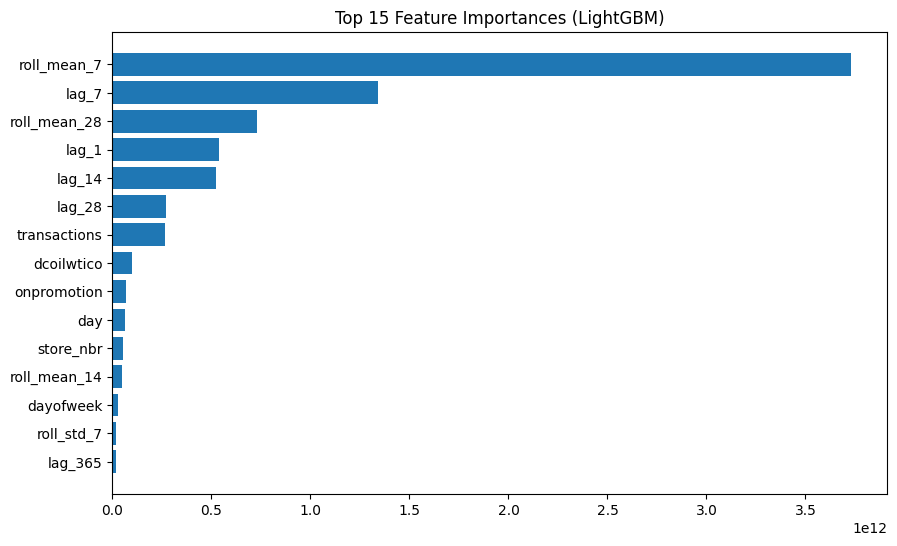

In [8]:
# =========================================================
# CELL 8 — Model Evaluation and Reporting
# =========================================================

from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt

# --- RMSE already computed ---
print(f" LightGBM Best Iteration: {model_lgb.best_iteration}")
print(f" LightGBM RMSE on validation: {rmse:.4f}")

# --- RMSLE ---
# We compute RMSLE to capture relative prediction errors,
# penalizing underestimation more than overestimation.
rmsle = np.sqrt(mean_squared_log_error(y_valid, np.maximum(y_pred_valid, 0)))
print(f"LightGBM RMSLE on validation: {rmsle:.4f}")

# --- Feature Importance ---
# Extract feature importance using "gain" (how much each feature
# contributes to reducing loss across all trees).
importance = model_lgb.feature_importance(importance_type="gain")
feature_imp = pd.DataFrame({
    "feature": model_lgb.feature_name(),
    "importance": importance
}).sort_values("importance", ascending=False)

# Plot the Top 15 most important features
plt.figure(figsize=(10, 6))
plt.barh(feature_imp["feature"][:15][::-1], feature_imp["importance"][:15][::-1])
plt.title("Top 15 Feature Importances (LightGBM)")
plt.show()



# 📤 Final Training & Submission

---

### 🔧 Procedure
1. **Feature Alignment**:  
   Train and test are concatenated to apply consistent lag and rolling window features.  
   Additional holiday dummies (`is_christmas`, `is_newyear`) and a yearly lag (`lag_365`) are engineered.  

2. **Categorical Encoding**:  
   `family` and `store_nbr` are explicitly marked as categorical, allowing LightGBM to handle them efficiently.  

3. **Final Training**:  
   - The full training set is used.  
   - Model is trained with the same hyperparameters as before.  
   - The **best iteration** (426) from the validation phase is reused to prevent overfitting.  

4. **Prediction**:  
   - Sales forecasts are generated for the test set.  
   - Negative predictions are clipped to zero.  

5. **Submission**:  
   - Predictions are paired with the `id` column to create `submission.csv`.  
   - File is saved in the correct format for Kaggle submission.  

---

### 📊 Output
The resulting file `submission.csv` contains:  

- `id`: Unique identifier for each (store, family, date)  
- `sales`: Predicted sales (non-negative)  

Example (first 5 rows):  

| id   | sales   |
|------|---------|
| 3000888 | 13.45 |
| 3000889 | 25.77 |
| 3000890 | 12.33 |
| 3000891 | 40.62 |
| 3000892 | 15.18 |

✅ **Ready for Kaggle submission!**


In [9]:
# =========================================================
# CELL 9 — Final Training & Submission
# =========================================================

# 1. Merge train and test to ensure consistent feature engineering
full_df = pd.concat([train, test], ignore_index=True)

# --- EXTRA FEATURE ENGINEERING ---
# Holiday dummies
full_df["is_christmas"] = (
    ((full_df["month"] == 12) & (full_df["day"] >= 20)) |
    ((full_df["month"] == 1) & (full_df["day"] <= 7))
).astype(int)

full_df["is_newyear"] = ((full_df["month"] == 1) & (full_df["day"] <= 3)).astype(int)

# Yearly lag (per store-family group)
full_df["lag_365"] = full_df.groupby(["store_nbr","family"])["sales"].shift(365)

# Encode categorical variables
full_df["family"] = full_df["family"].astype("category")
full_df["store_nbr"] = full_df["store_nbr"].astype("category")

# 2. Split back into train and test
train_final = full_df.loc[full_df["date"] < test["date"].min()].copy()
test_final  = full_df.loc[full_df["date"] >= test["date"].min()].copy()

# 3. Define features and target
X = train_final[feature_cols]
y = train_final["sales"]
X_test = test_final[feature_cols]

# 4. LightGBM Dataset
final_train = lgb.Dataset(X, label=y, categorical_feature=["store_nbr", "family"])

# 5. Train final model using best iteration from validation phase
final_model = lgb.train(
    params=params,
    train_set=final_train,
    num_boost_round=model_lgb.best_iteration
)

# 6. Predict on test set
y_test_pred = final_model.predict(X_test, num_iteration=final_model.best_iteration)
y_test_pred = np.maximum(y_test_pred, 0)  # enforce non-negative predictions

# 7. Create submission file
submission = pd.DataFrame({
    "id": test_final["id"],
    "sales": y_test_pred
})

submission.to_csv("submission.csv", index=False)
print("✅ submission.csv created!")
submission.head()




✅ submission.csv created!


,id,sales
1079892,3000888,0.0
1079893,3002670,0.0
1079894,3004452,0.0
1079895,3006234,0.0
1079896,3008016,0.0
